<div style="color:white;
            display:fill;
            border-radius:15px;
            background-color:skyblue;
            font-size:100%;
            font-family:Verdana;
            letter-spacing:1px">
    <h2 style='padding: 20px;
              color:black;
              text-align:center;'>
        FLIGHT FARE PREDICTION
    </h2>
    </div>

Problem Statement: Finding the ideal number of days left to book a ticket 


Air travel takes the top spot when time is a major constraint for duration of travel. The same factor also has impact on the ticket fare. The ticket booking time has a great impact on the price of the ticket. 

In the current analysis we are trying to understand the impact of different attributes on the price of the ticket.

Dataset Overview:

Ticket booking information for tickets booked on 10th Feb, 2022 for date of travel ranging from 11th Feb, 2022 and 31st March, 2022. Dataset is based on  domestic flight ticket.

https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?datasetId=1957837&sortBy=voteCount

This Dataset offer a range of data, including historical ticket prices, flight schedules and economic indicators that can be used to build predictive models. Additionally this data analysis can be used to gather specific information on airlines, routes, and pricing trends.



In [37]:
# need to import the numpy library
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import time, datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)

In [38]:
# Check if input file is present
# business.csv , economy.csv
import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Clean_flight_data.csv
./economy.csv
./business.csv
./Flight_ticket_prediction_v2.ipynb


In [39]:
# loading business class file in df named b
b = pd.read_csv("business.csv")
b.head(5)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


In [40]:
# loading economy class file in df named e
e = pd.read_csv("economy.csv")
e.head(5)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953"
1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953"
2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956"
3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955"
4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955"


In [41]:
#adding the new column named class
b["class"] = "business" 
e["class"] = "economy"

In [42]:
# appending two data sets and storing in the new data frame
flight_data = e.append(b,ignore_index = True)
flight_data.head(1)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
flight_data = pd.concat([e, b], ignore_index=True)

In [ ]:
# merging two columns (ch_code and "num_code") and create new column flight ( flight number)
flight_data.num_code = flight_data.num_code.astype("str")
flight_data["flight"] = flight_data["ch_code"] +"-"+ flight_data["num_code"]
flight_data.drop(["ch_code","num_code"],axis = 1,inplace = True)

In [ ]:
# renaming the columns
flight_data.rename({"dep_time": "departure_time", "from": "source_city", 
            "time_taken": "duration", "stop": "stops", "arr_time": "arrival_time",
           "to":"destination_city"}, axis = 1, inplace = True)

In [ ]:
# Calculate number of days for travel from booking date i.e data was captured for all tickets booked on Feb 10th 2022
flight_data["days_left"] = (pd.to_datetime(flight_data["date"], format='%d-%m-%Y' ) - pd.to_datetime('10-02-2022', format='%d-%m-%Y')).dt.days
flight_data.head(2)

,date,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,11-02-2022,SpiceJet,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",economy,SG-8709,1
1,11-02-2022,SpiceJet,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",economy,SG-8157,1


In [ ]:
#dropping the date column
flight_data.drop("date",axis = 1,inplace = True)

In [ ]:
# converting arrival time and departure time into morning/noon/evening, etc
# Late Night : 12 AM to 3:59:59 AM
# Early Morning : 4 AM to 7:59:59 AM
# Morning : 8 AM to 11:59:59 PM
# Afternoon : 12 PM to 3:59:59 PM
# Evening : 4PM to 7:59:59 PM
# Night : 8 PM to 11:59:59 AM
s = (pd.to_datetime(flight_data["departure_time"]).dt.hour) // 4 #give numbers from 1 to 6 #(return a series)
s.replace({0: 'Late Night', 1: 'Early Morning', 2: 'Morning', 
                      3: 'Afternoon', 4: 'Evening', 5: 'Night'} ,inplace = True) # to replace values 1:latenight to 6: night
flight_data["departure_time"] = s 

t = (pd.to_datetime(flight_data["arrival_time"]).dt.hour ) // 4 #give numbers from 1 to 6 #(return a series)
t.replace({0: 'Late Night', 1: 'Early Morning', 2: 'Morning', 
                      3: 'Afternoon', 4: 'Evening', 5: 'Night'} ,inplace = True) # to replace values 1:latenight to 6: night
flight_data["arrival_time"] = t
flight_data.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,02h 10m,non-stop,Night,Mumbai,"5,953",economy,SG-8709,1


In [ ]:
#converting duration into minutes
temp = pd.DataFrame(flight_data["duration"].str.split(expand = True).to_numpy().astype(str), 
                    columns = ["hours","minutes"])
# temp = [{"hours","columns"},{"02h","10m"}]
temp["minutes"] = temp["minutes"].apply(lambda r: re.sub("[^0-9]","",r))
temp["hours"] = temp["hours"].apply(lambda r: re.sub("[^0-9]","",r))
temp["minutes"] = np.where(temp["minutes"] == "", 0, temp["minutes"])
temp["minutes"] = temp["minutes"].astype(int)
temp["hours"] = temp["hours"].astype(int)
flight_data["duration"] = temp["hours"]*60 + temp["minutes"]
flight_data.head(10)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,130,non-stop,Night,Mumbai,"5,953",economy,SG-8709,1
1,SpiceJet,Early Morning,Delhi,140,non-stop,Morning,Mumbai,"5,953",economy,SG-8157,1
2,AirAsia,Early Morning,Delhi,130,non-stop,Early Morning,Mumbai,"5,956",economy,I5-764,1
3,Vistara,Morning,Delhi,135,non-stop,Afternoon,Mumbai,"5,955",economy,UK-995,1
4,Vistara,Morning,Delhi,140,non-stop,Morning,Mumbai,"5,955",economy,UK-963,1
5,Vistara,Morning,Delhi,140,non-stop,Afternoon,Mumbai,"5,955",economy,UK-945,1
6,Vistara,Morning,Delhi,125,non-stop,Morning,Mumbai,"6,060",economy,UK-927,1
7,Vistara,Afternoon,Delhi,130,non-stop,Evening,Mumbai,"6,060",economy,UK-951,1
8,GO FIRST,Morning,Delhi,130,non-stop,Morning,Mumbai,"5,954",economy,G8-334,1
9,GO FIRST,Afternoon,Delhi,135,non-stop,Evening,Mumbai,"5,954",economy,G8-336,1


In [ ]:
# replacing the stops with just number
flight_data["stops"] = flight_data["stops"].apply(lambda r: re.sub("[^0-9]","",r)) # taking only digits
flight_data["stops"] = np.where(flight_data["stops"] == "", 0, flight_data["stops"]) # replacing "" with 0
flight_data["stops"] = flight_data["stops"].astype(int) # changing object to int

In [ ]:
# removing noise from price column
flight_data["price"] = flight_data["price"].apply(lambda r: re.sub("[^0-9]","",r)) # taking only digits
flight_data["price"] = flight_data["price"].astype(int) # changing object to int
flight_data.head(1)

,airline,departure_time,source_city,duration,stops,arrival_time,destination_city,price,class,flight,days_left
0,SpiceJet,Evening,Delhi,130,0,Night,Mumbai,5953,economy,SG-8709,1


In [ ]:
# arranging the columns 
flight_data = flight_data[["airline","flight","source_city","departure_time","stops",
     "arrival_time","destination_city","class","duration","days_left","price"]]

In [ ]:
flight_data.head(15)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,economy,130,1,5953
1,SpiceJet,SG-8157,Delhi,Early Morning,0,Morning,Mumbai,economy,140,1,5953
2,AirAsia,I5-764,Delhi,Early Morning,0,Early Morning,Mumbai,economy,130,1,5956
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,economy,135,1,5955
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,economy,140,1,5955
5,Vistara,UK-945,Delhi,Morning,0,Afternoon,Mumbai,economy,140,1,5955
6,Vistara,UK-927,Delhi,Morning,0,Morning,Mumbai,economy,125,1,6060
7,Vistara,UK-951,Delhi,Afternoon,0,Evening,Mumbai,economy,130,1,6060
8,GO FIRST,G8-334,Delhi,Morning,0,Morning,Mumbai,economy,130,1,5954
9,GO FIRST,G8-336,Delhi,Afternoon,0,Evening,Mumbai,economy,135,1,5954


In [ ]:
# exporting the file in csv
flight_data.to_csv("Clean_flight_data.csv", index = False)

In [ ]:
df=pd.read_csv('Clean_flight_data.csv')
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,economy,130,1,5953
1,SpiceJet,SG-8157,Delhi,Early Morning,0,Morning,Mumbai,economy,140,1,5953
2,AirAsia,I5-764,Delhi,Early Morning,0,Early Morning,Mumbai,economy,130,1,5956
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,economy,135,1,5955
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,economy,140,1,5955


**Overview of Dataframe**

In [ ]:
df.shape

(300261, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   airline           300261 non-null  object
 1   flight            300261 non-null  object
 2   source_city       300261 non-null  object
 3   departure_time    300261 non-null  object
 4   stops             300261 non-null  int64 
 5   arrival_time      300261 non-null  object
 6   destination_city  300261 non-null  object
 7   class             300261 non-null  object
 8   duration          300261 non-null  int64 
 9   days_left         300261 non-null  int64 
 10  price             300261 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 25.2+ MB


In [ ]:
df.describe()

,stops,duration,days_left,price
count,300261.000000,300261.000000,300261.000000,300261.000000
mean,0.924213,733.146346,26.004473,20883.717666
std,0.398188,432.019427,13.560985,22695.911266
min,0.000000,50.000000,1.000000,1105.000000
25%,1.000000,405.000000,15.000000,4783.000000
50%,1.000000,675.000000,26.000000,7425.000000
75%,1.000000,970.000000,38.000000,42521.000000
max,2.000000,6180.000000,49.000000,123071.000000


In [ ]:
df.corr().T

,stops,duration,days_left,price
stops,1.000000,0.467928,-0.008566,0.119798
duration,0.467928,1.000000,-0.039208,0.204133
days_left,-0.008566,-0.039208,1.000000,-0.091917
price,0.119798,0.204133,-0.091917,1.000000


Price and Duration has a correlation of 0.2 i.e Price increases proportionally with the duration of travel.For economy class, the correlation of days left for travel and the price is inversely proportional (-0.55) i.e price increases when number of days left for travel is less

In [ ]:
df[df['class']=='economy'].corr().T

ValueError: could not convert string to float: 'SpiceJet'

Impact of days left to travel on price is less on Business class tickets i.e correlation is close to 0 (-0.09)

In [ ]:
df[df['class']=='business'].corr().T

,stops,duration,days_left,price
stops,1.000000,0.478045,-0.003931,0.593847
duration,0.478045,1.000000,-0.026587,0.242729
days_left,-0.003931,-0.026587,1.000000,-0.091289
price,0.593847,0.242729,-0.091289,1.000000


In [ ]:
# Since economy and business have completely different correlations when split, we might want to understand patterns for each class
economy_df = df[df['class']=='economy']
business_df = df[df['class']=='business']

In [ ]:
economy_df.shape

(206774, 11)

In [ ]:
df1=df.groupby(['airline','flight'],as_index=True).count()
df1

source_city  departure_time  stops  arrival_time  \
airline   flight                                                     
Air India AI-401          492             492    492           492   
          AI-402         1532            1532   1532          1532   
          AI-403           68              68     68            68   
          AI-406          120             120    120           120   
          AI-407           21              21     21            21   
...                       ...             ...    ...           ...   
Vistara   UK-988         1381            1381   1381          1381   
          UK-993          911             911    911           911   
          UK-994         1273            1273   1273          1273   
          UK-995         1024            1024   1024          1024   
          UK-996         1266            1266   1266          1266   

                  destination_city  class  duration  days_left  price  
airline   flight                                                       
Air India AI-401               492    492       492        492    492  
          AI-402              1532   1532      1532       1532   1532  
          AI-403                68     68        68         68     68  
          AI-406               120    120       120        120    120  
          AI-407                21     21        21         21     21  
...                            ...    ...       ...        ...    ...  
Vistara   UK-988              1381   1381      1381       1381   1381  
          UK-993               911    911       911        911    911  
          UK-994              1273   1273      1273       1273   1273  
          UK-995              1024   1024      1024       1024   1024  
          UK-996              1266   1266      1266       1266   1266  

[1569 rows x 9 columns]

In [ ]:
df1=df.groupby(['airline','flight'],as_index=False).count()
df1['airline'].value_counts()

airline
Indigo       704
Air India    218
GO FIRST     205
SpiceJet     186
Vistara      133
AirAsia      115
StarAir        4
Trujet         4
Name: count, dtype: int64

Indigo has more number of flights being operated compared to other Airlines

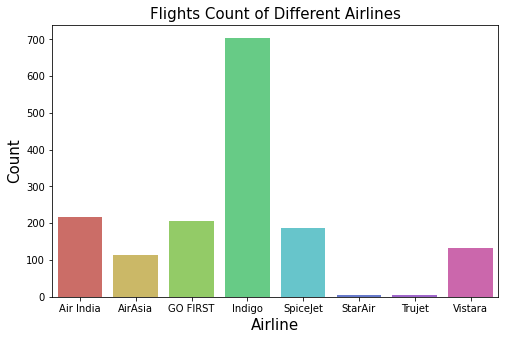

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(df1['airline'],palette='hls')
plt.title('Flights Count of Different Airlines',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

In [ ]:
# Number of flights available for Economy and Business class
df3=df.groupby(['flight','airline','class'],as_index=False).count()

df3['class'].value_counts()

class
economy     1568
business     295
Name: count, dtype: int64

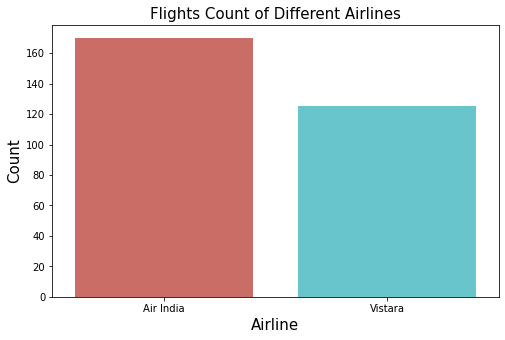

In [ ]:
# Within Business class only Air India and Vistara have business class services
bdf1=business_df.groupby(['airline','flight'],as_index=False).count()
bdf1['airline'].value_counts()
plt.figure(figsize=(8,5))
sns.countplot(bdf1['airline'],palette='hls')
plt.title('Flights Count of Different Airlines',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

Trying to find average price of ticket for each class between cities for different airlines, to understand if there is any pattern

In [ ]:
df2=df.groupby(['airline','source_city','destination_city','class'],as_index=False)['price'].mean()
df2['price'] = np.ceil(df2['price'])
df2

,airline,source_city,destination_city,class,price
0,Air India,Bangalore,Chennai,business,56302.0
1,Air India,Bangalore,Chennai,economy,8220.0
2,Air India,Bangalore,Delhi,business,40609.0
3,Air India,Bangalore,Delhi,economy,6788.0
4,Air India,Bangalore,Hyderabad,business,51170.0
...,...,...,...,...,...
238,Vistara,Mumbai,Delhi,economy,6922.0
239,Vistara,Mumbai,Hyderabad,business,55571.0
240,Vistara,Mumbai,Hyderabad,economy,6232.0
241,Vistara,Mumbai,Kolkata,business,62526.0


Fixing a source, destination and airline, we have found that ticket price for 1 stop flights is more than that of a non stop flight, more analysis on this to follow

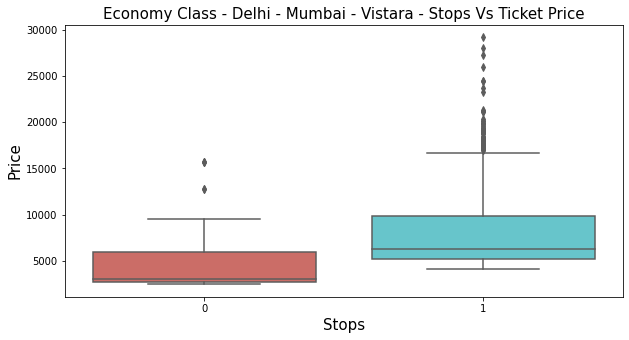

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='stops',y='price',data=df[(df['source_city']=='Delhi')& (df['destination_city']=='Mumbai')&(df['class']=='economy')&(df['airline']=='Vistara')],palette='hls')
plt.title('Economy Class - Delhi - Mumbai - Vistara - Stops Vs Ticket Price',fontsize=15)
plt.xlabel('Stops',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<b> Does price vary with Airlines?</b>

<p>
    
<ul>
    <li>Vistara and Air_India Airlines Have Maximum Price when compared to Others</li>
  
    
</ul>
</p>

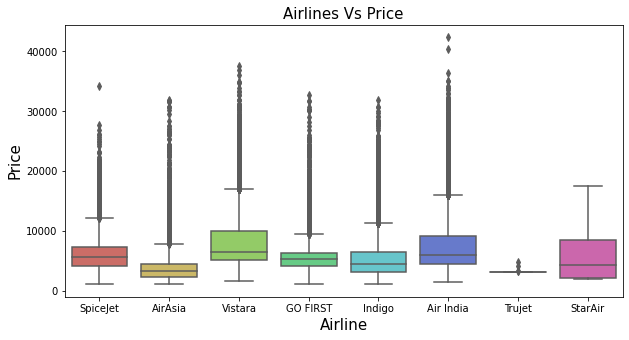

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x=economy_df['airline'],y=df['price'],palette='hls')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<p>
    <b> How Does the Ticket Price vary between Economy and Business Class?</b>
   
<ul> 
    <li>Ticket Price range is higher for Business Class with around 16k When compared to Economy Class 4k (Interquartile range)</li>
</ul>
    </p>

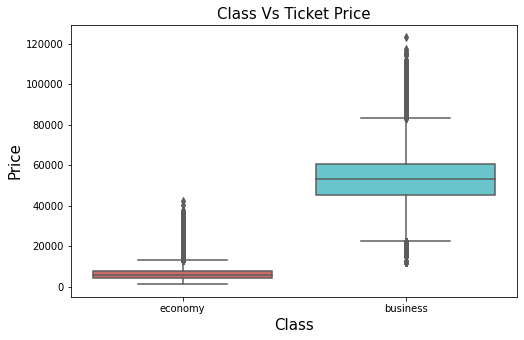

In [ ]:
plt.figure(figsize=(8,5))
#ax = sns.boxplot(x='class', y='price', data=df, palette='hls')
sns.boxplot(x='class',y='price',data=df,palette='hls')
plt.title('Class Vs Ticket Price',fontsize=15)
plt.xlabel('Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
#ax.set_ylim(bottom = 0, top = 85000)
plt.show()

In [ ]:
df[df['class']=='business'][['class','price']].describe()

,price
count,93487.000000
mean,52540.081124
std,12969.314606
min,12000.000000
25%,45185.000000
50%,53164.000000
75%,60396.000000
max,123071.000000


In [ ]:
df[df['class']=='economy'][['class','price']].describe()

,price
count,206774.000000
mean,6571.190701
std,3743.442838
min,1105.000000
25%,4173.000000
50%,5772.000000
75%,7746.000000
max,42349.000000


<b> How Does the Ticket Price vary with the number of stops of a Flight?</b>

<p> 
<ul><li>Flights having the maximum number of stops has the maximum ticket price, the reason being that there are extra costs associated with stops which a non-stop flight doesn't have. Some of them could be landing costs, baggage handling, ground crews, longer duty hours for flight crew, terminal expenses etc., </li></ul>
</p>

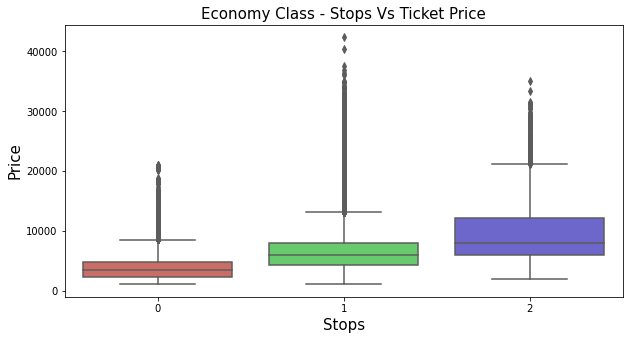

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='stops',y='price',data=economy_df,palette='hls')
plt.title('Economy Class - Stops Vs Ticket Price',fontsize=15)
plt.xlabel('Stops',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

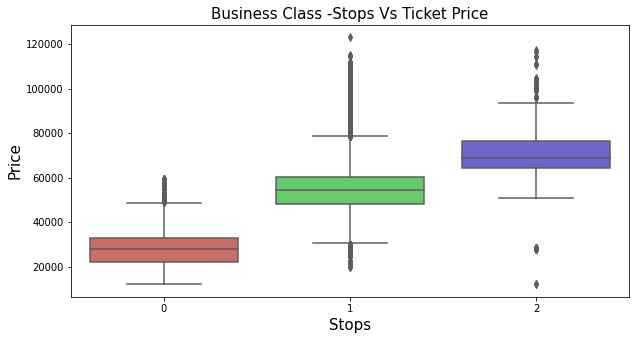

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='stops',y='price',data=business_df,palette='hls')
plt.title('Business Class -Stops Vs Ticket Price',fontsize=15)
plt.xlabel('Stops',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<p>
    
<b> How does the Ticket Price change based on the Departure Time and Arrival Times?</b><br>

    
<b>1. Departure Time Vs Ticket Price</b>

   <!-- <ul>
   <li> Ticket Price is More for the Flights when the Departure Time is at Night</li>
   <li>Ticket Price is almost equal for flights Having Departure time at Early_morning , Morning and Evening</li>
   <li>Ticket Price is Low for the Flights Having Departure Time at Late_night</li>
   </ul> -->
    
 
 
<b>2. Arrival Time Vs Ticket Price</b>

   <!-- <ul>
    <li>Ticket Price is More for the Flights when the Arrival Time is at Evening</li>
    <li>Ticket Price is almost equal for flights Having Arrival time is at Morning and Night</li>
   <li>Ticket Price is Low for the Flights Having Arrival Time at Late_night as same as Departure Time</li>
    </ul> -->
 </p>

In [ ]:
# plt.figure(figsize=(24,10))
# plt.subplot(1,2,1)
# sns.boxplot(x='departure_time',y='price',data=df)
# plt.title('Departure Time Vs Ticket Price',fontsize=20)
# plt.xlabel('Departure Time',fontsize=15)
# plt.ylabel('Price',fontsize=15)
# plt.subplot(1,2,2)
# sns.boxplot(x='arrival_time',y='price',data=df,palette='hls')
# plt.title('Arrival Time Vs Ticket Price',fontsize=20)
# plt.xlabel('Arrival Time',fontsize=15)
# plt.ylabel('Price',fontsize=15)
# plt.show()

There are differences in arrival & departure times vs ticket prices in economy and overall, what is the conclusion? ANSWER THIS

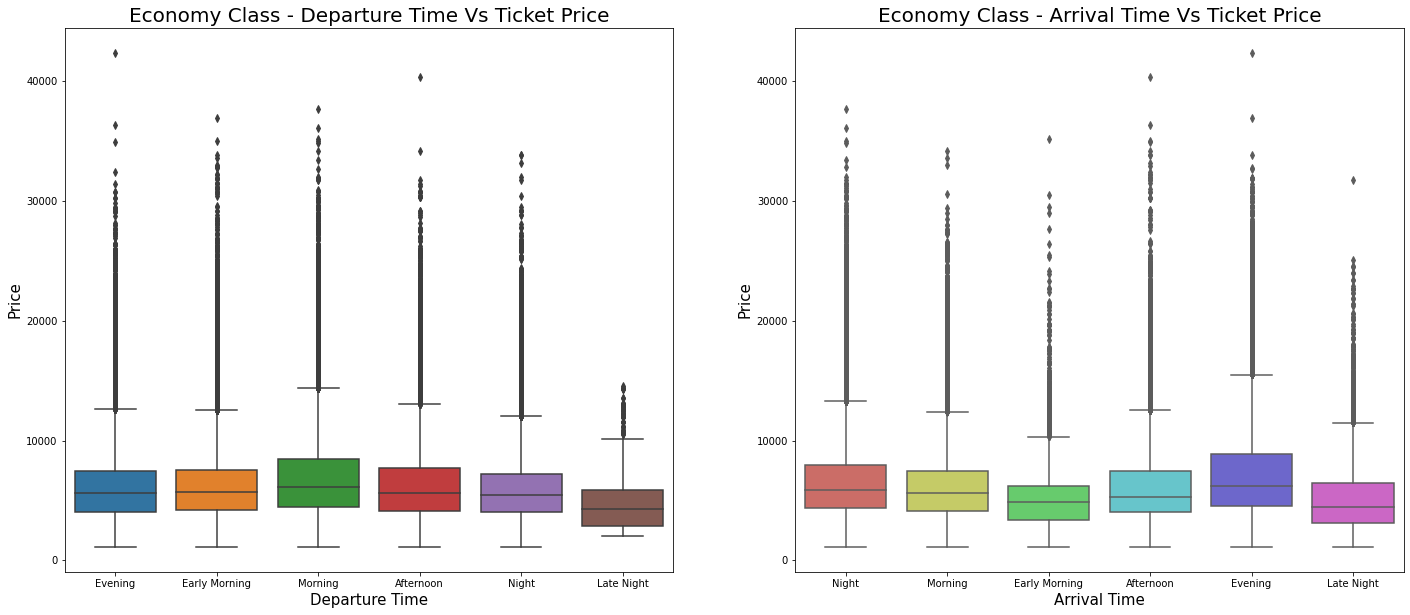

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='departure_time',y='price',data=economy_df)
plt.title('Economy Class - Departure Time Vs Ticket Price',fontsize=20)
plt.xlabel('Departure Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='arrival_time',y='price',data=economy_df,palette='hls')
plt.title('Economy Class - Arrival Time Vs Ticket Price',fontsize=20)
plt.xlabel('Arrival Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

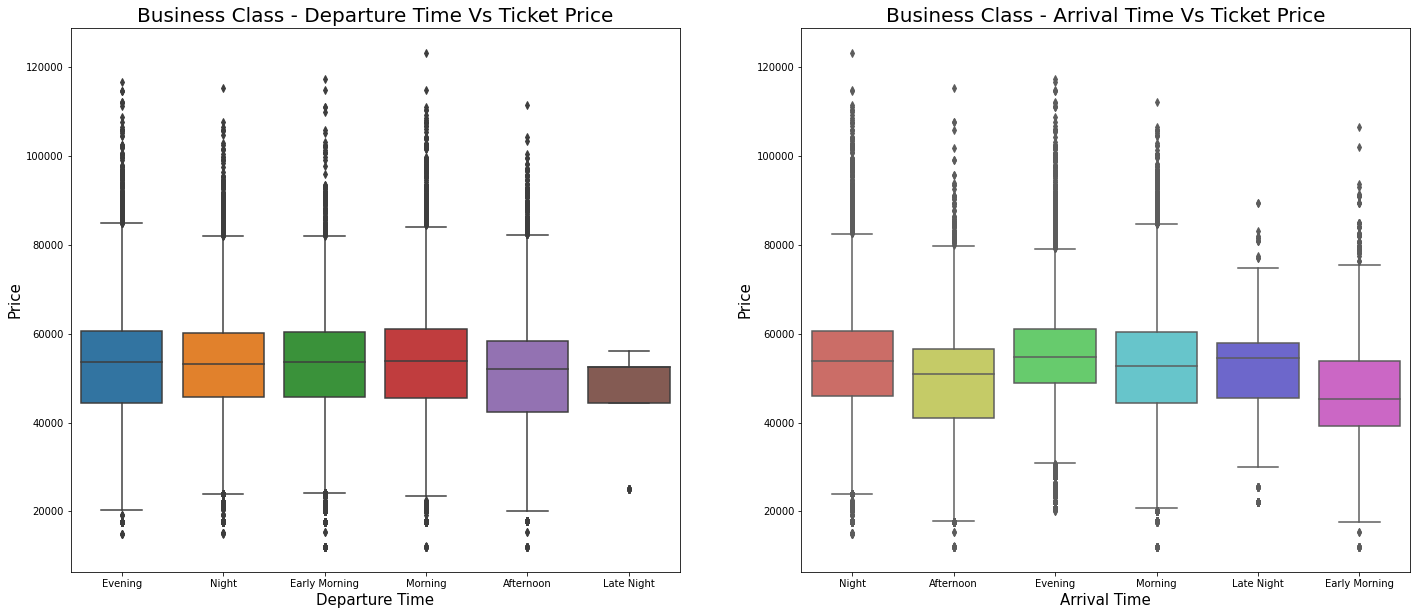

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='departure_time',y='price',data=business_df)
plt.title('Business Class - Departure Time Vs Ticket Price',fontsize=20)
plt.xlabel('Departure Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='arrival_time',y='price',data=business_df,palette='hls')
plt.title('Business Class - Arrival Time Vs Ticket Price',fontsize=20)
plt.xlabel('Arrival Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<p>
<b> How the price changes with change in Source city and Destination city?</b><br>
    
<b>1. Source City Vs Ticket Price</b>
<!-- 
   <li> Ticket Price is More for the Flights whose Source City is Kolkata</li>
   <li>Ticket Price is almost equal for flights Having Source Cities as Mumbai and chennai , Hyderabad and Bangalore</li>
    <li> Ticket Price is Low for the Flights Having Source City as Delhi</li>
     -->
 
<b>2. Destination City Vs Ticket Price</b>

   <!-- <li> Ticket Price is More for the Flights whose Destination City is kolkata and Chennai</li>
   <li> Ticket Price is almost equal for flights Having Destination Cities as Mumbai and Bangalore</li>
   <li>Ticket Price is Low for the Flights Having Destination City as Delhi</li> -->
</p>

In [ ]:
# plt.figure(figsize=(24,10))
# plt.subplot(1,2,1)
# sns.boxplot(x='source_city',y='price',data=df)
# plt.title('Source City Vs Ticket Price',fontsize=20)
# plt.xlabel('Source City',fontsize=15)
# plt.ylabel('Price',fontsize=15)
# plt.subplot(1,2,2)
# sns.boxplot(x='destination_city',y='price',data=df,palette='hls')
# plt.title('Destination City Vs Ticket Price',fontsize=20)
# plt.xlabel('Destination City',fontsize=15)
# plt.ylabel('Price',fontsize=15)
# plt.show()

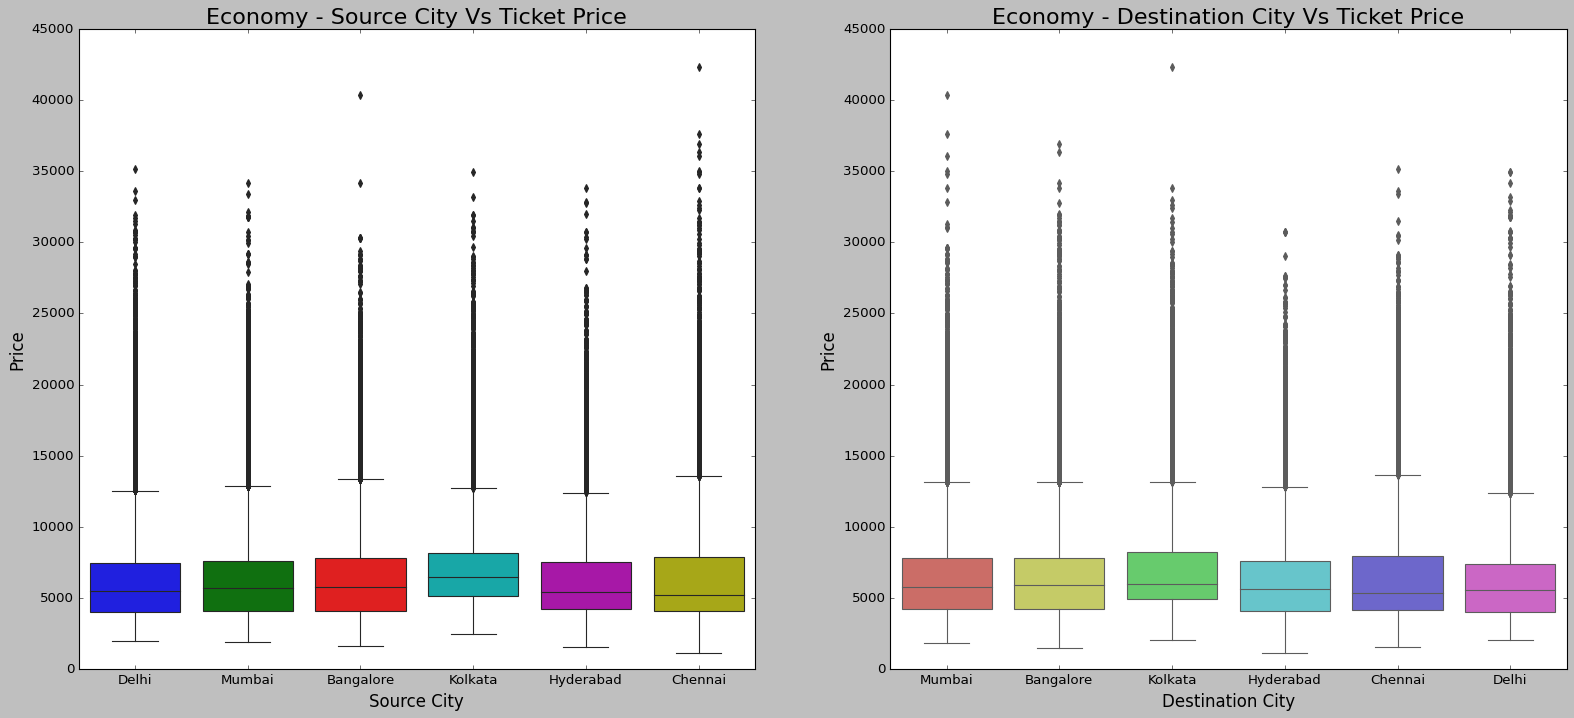

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city',y='price',data=economy_df)
plt.title('Economy - Source City Vs Ticket Price',fontsize=20)
plt.xlabel('Source City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city',y='price',data=economy_df,palette='hls')
plt.title('Economy - Destination City Vs Ticket Price',fontsize=20)
plt.xlabel('Destination City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [ ]:
# Number of flights per each city starting and destination counts
economy_df.groupby(['source_city','flight'],as_index=False).count().groupby(['source_city'],as_index=False)['flight'].count().sort_values(['flight'], ascending = False)

,source_city,flight
2,Delhi,471
5,Mumbai,324
0,Bangalore,267
4,Kolkata,206
3,Hyderabad,195
1,Chennai,156


In [ ]:
economy_df.groupby(['destination_city','flight'],as_index=False).count().groupby(['destination_city'],as_index=False)['flight'].count().sort_values(['flight'], ascending = False)

,destination_city,flight
4,Kolkata,771
2,Delhi,714
0,Bangalore,656
5,Mumbai,646
3,Hyderabad,566
1,Chennai,536


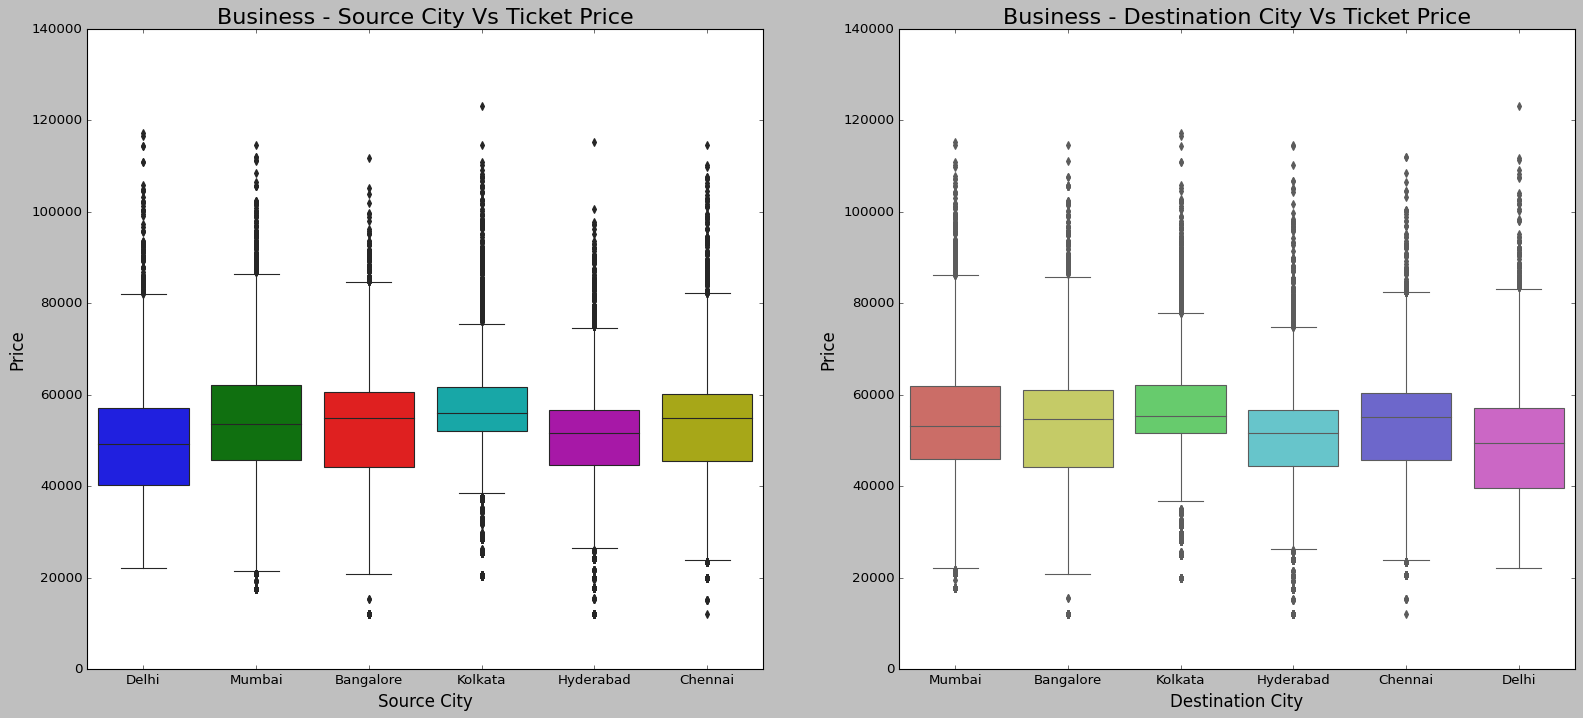

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city',y='price',data=business_df)
plt.title('Business - Source City Vs Ticket Price',fontsize=20)
plt.xlabel('Source City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city',y='price',data=business_df,palette='hls')
plt.title('Business - Destination City Vs Ticket Price',fontsize=20)
plt.xlabel('Destination City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [ ]:
business_df.groupby(['source_city','flight'],as_index=False).count().groupby(['source_city'],as_index=False)['flight'].count().sort_values(['flight'], ascending = False)

,source_city,flight
2,Delhi,112
5,Mumbai,79
0,Bangalore,36
4,Kolkata,31
3,Hyderabad,24
1,Chennai,21


In [ ]:
business_df.groupby(['destination_city','flight'],as_index=False).count().groupby(['destination_city'],as_index=False)['flight'].count().sort_values(['flight'], ascending = False)

,destination_city,flight
5,Mumbai,197
4,Kolkata,187
2,Delhi,184
1,Chennai,180
0,Bangalore,177
3,Hyderabad,171


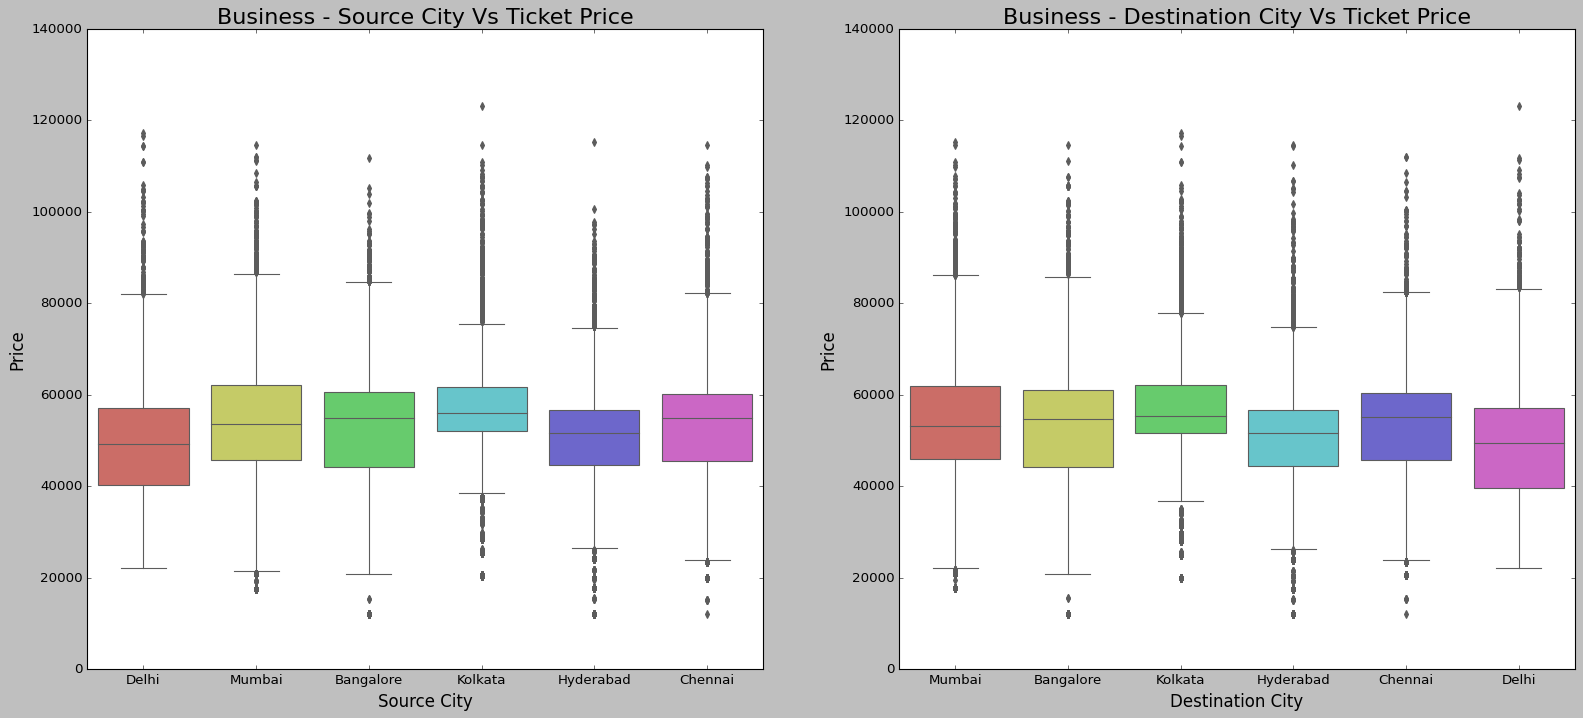

In [ ]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='source_city',y='price',data=business_df,palette='hls')
plt.title('Business - Source City Vs Ticket Price',fontsize=20)
plt.xlabel('Source City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='destination_city',y='price',data=business_df,palette='hls')
plt.title('Business - Destination City Vs Ticket Price',fontsize=20)
plt.xlabel('Destination City',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<p>
    <b> How Price Varies with the Flight Duration Based on Class?</b>

<li> With increase in Duration, the ticket price also increases in both the Economy and Business classes</li>
</p>


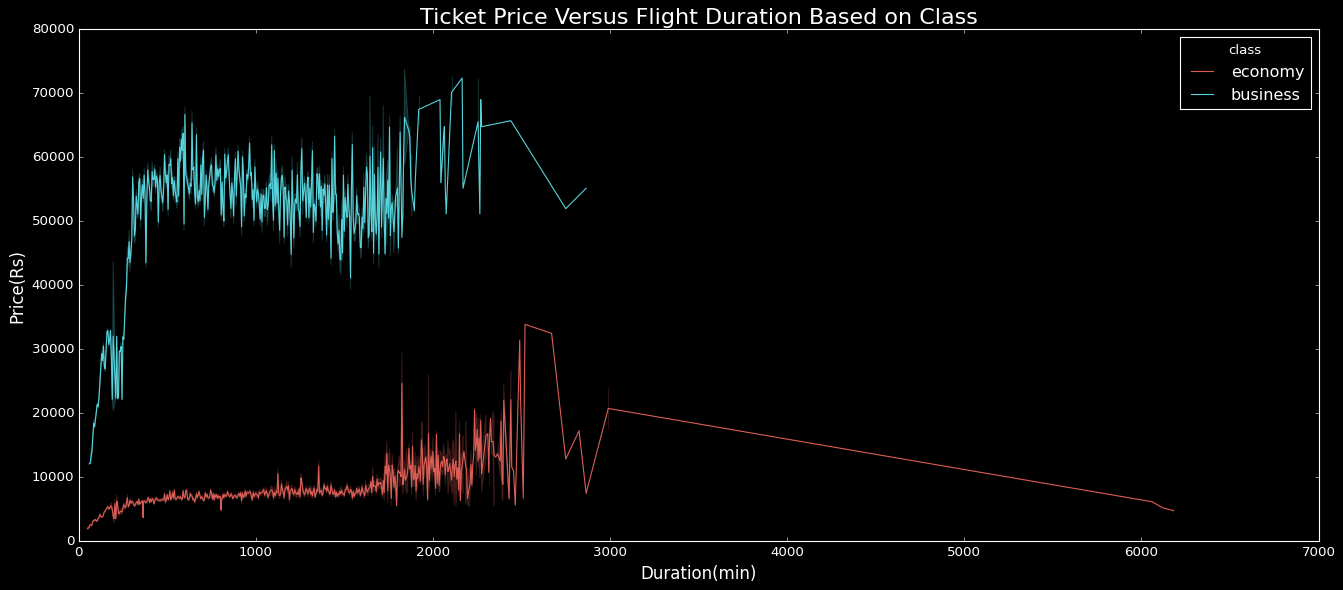

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='duration',y='price',hue='class',palette='hls')
plt.title('Ticket Price Versus Flight Duration Based on Class',fontsize=20)
plt.xlabel('Duration(min)',fontsize=15)
plt.ylabel('Price(Rs)',fontsize=15)
plt.show()

<p>
    <b> How does the price affected on the days left for Departure?</b>
    
<li> As we can see when compared to others when there are two days remaining for departure then the Ticket Price is very High for all airlines</li>
    
</p>

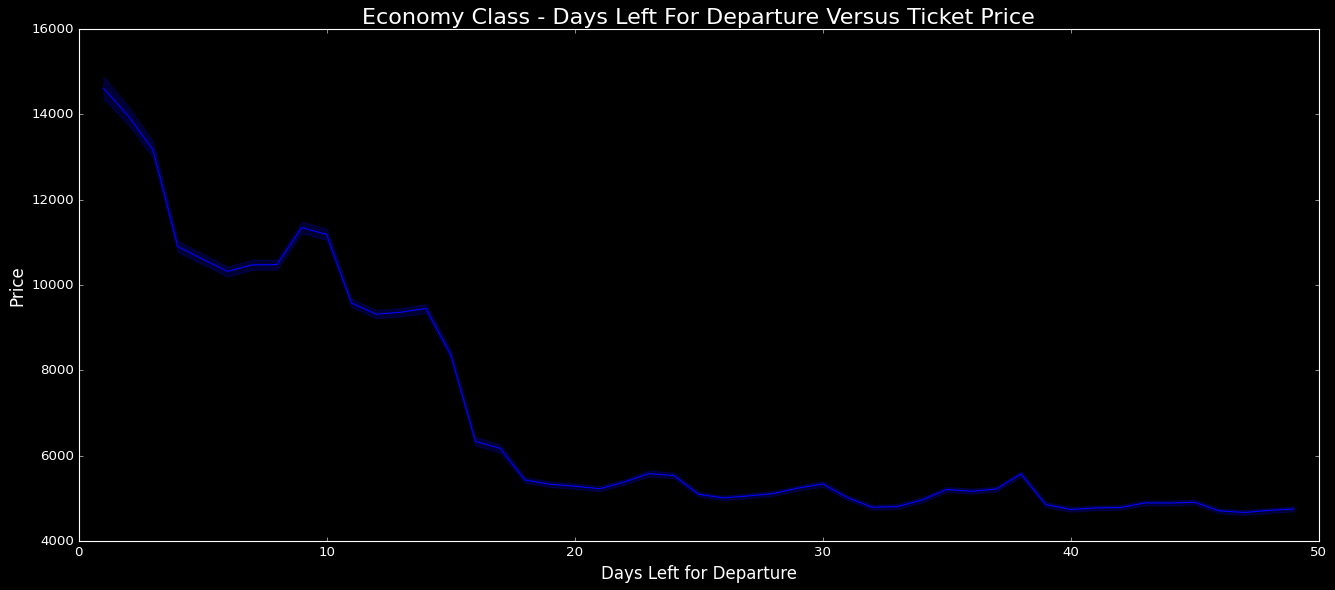

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=economy_df,x='days_left',y='price',color='blue')
plt.title('Economy Class - Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

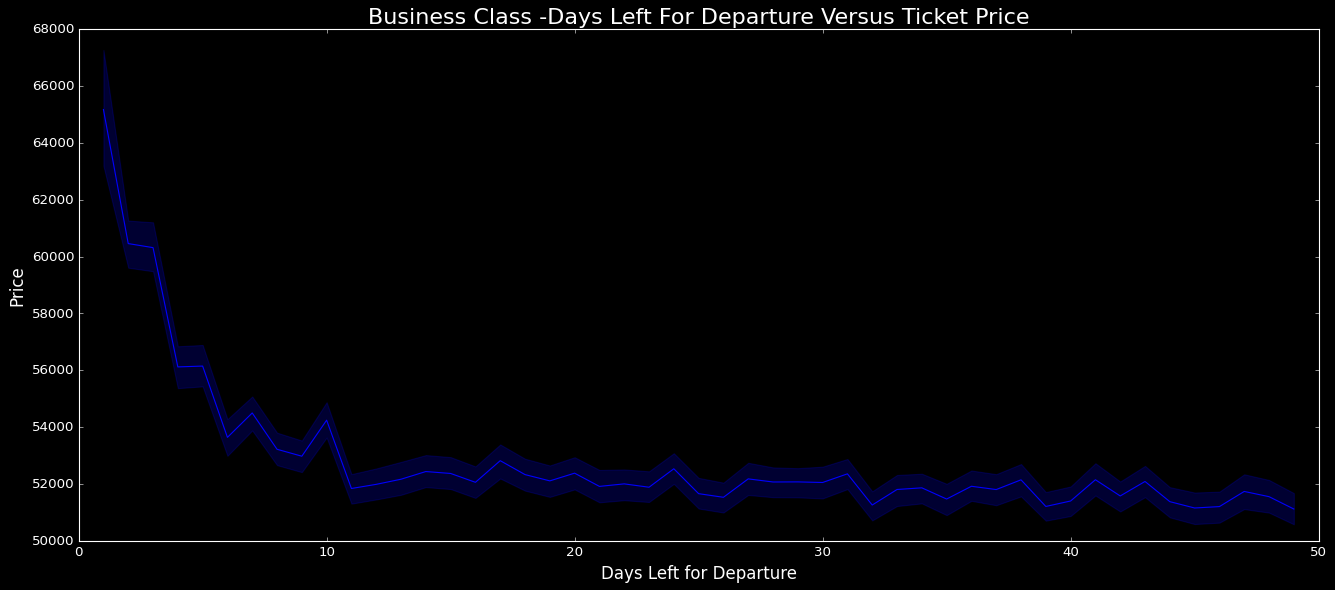

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=business_df,x='days_left',y='price',color='blue')
plt.title('Business Class -Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

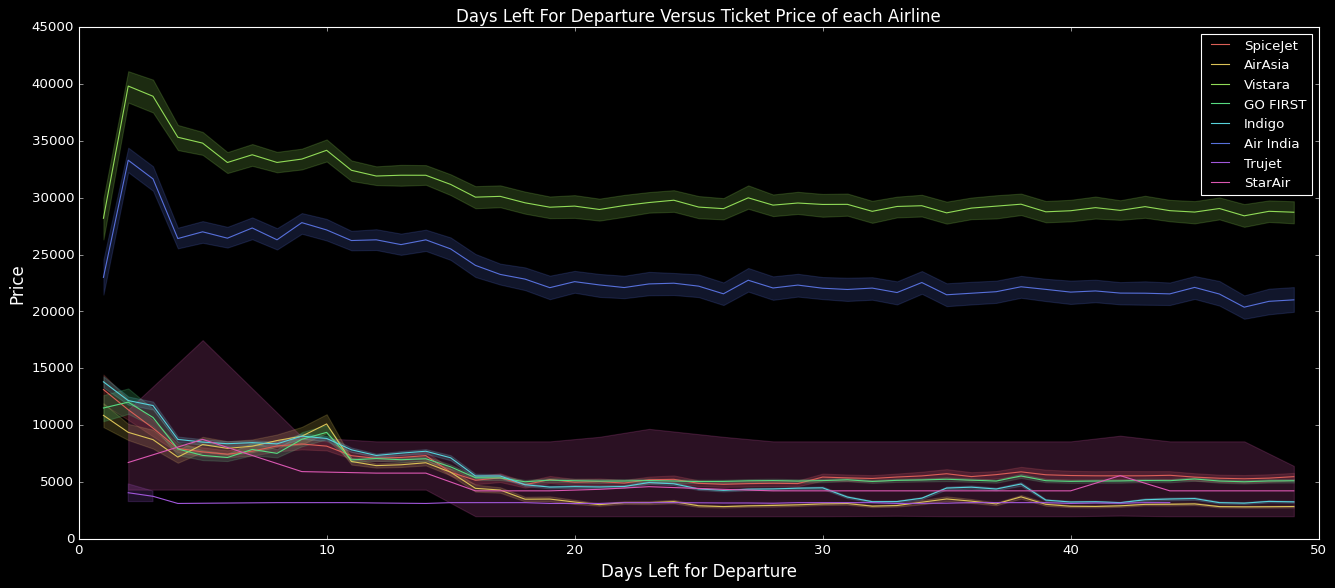

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=df,x='days_left',y='price',color='blue',hue='airline',palette='hls')
plt.title('Days Left For Departure Versus Ticket Price of each Airline',fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

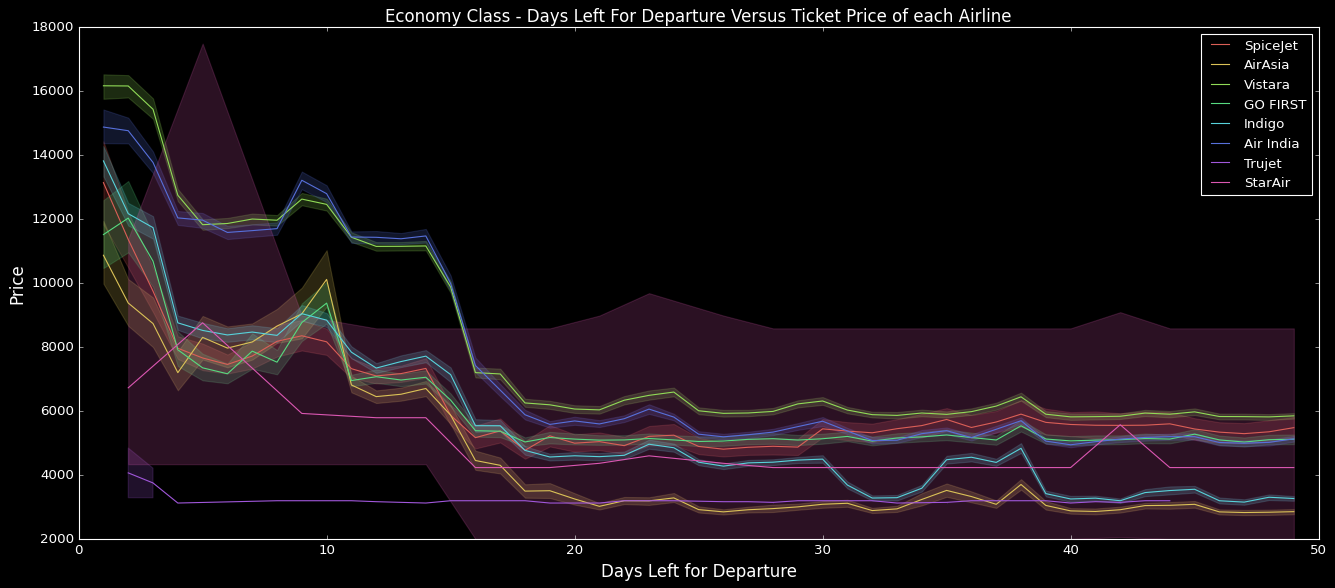

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=economy_df,x='days_left',y='price',color='blue',hue='airline',palette='hls')
plt.title('Economy Class - Days Left For Departure Versus Ticket Price of each Airline',fontsize=15)
plt.legend(fontsize=12)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

<b> Total number of Flights from one city to another</b>

In [ ]:
 df.groupby(['flight','source_city','destination_city','airline','class'],as_index=False).count().groupby(['source_city','destination_city'],as_index=False)['flight'].count().sort_values(by='flight', ascending = False).head(10)

,source_city,destination_city,flight
14,Delhi,Mumbai,364
10,Delhi,Bangalore,310
13,Delhi,Kolkata,306
27,Mumbai,Delhi,282
11,Delhi,Chennai,258
29,Mumbai,Kolkata,240
25,Mumbai,Bangalore,228
1,Bangalore,Delhi,227
12,Delhi,Hyderabad,224
22,Kolkata,Delhi,185


In [43]:
object_key = "raw/sample5.txt"
ext = object_key.split(".")[-1]
print(ext)
filename_with_ext = object_key.split("/")[-1]
print(filename_with_ext)
filename_without_ext = ".".join(filename_with_ext.split(".")[:-1])
print(filename_without_ext)

txt
sample5.txt
sample5


<b> Average Price of different Airlnes from Source city to Destination city</b>

In [ ]:
df.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean().sort_values(by='price', ascending = False).head(10)

,airline,source_city,destination_city,price
156,Vistara,Bangalore,Kolkata,35746.714874
166,Vistara,Delhi,Kolkata,35702.441732
182,Vistara,Mumbai,Kolkata,35223.862417
178,Vistara,Mumbai,Bangalore,35029.880315
157,Vistara,Bangalore,Mumbai,34961.383271
175,Vistara,Kolkata,Delhi,33792.181332
173,Vistara,Kolkata,Bangalore,33501.412807
177,Vistara,Kolkata,Mumbai,33416.101911
162,Vistara,Chennai,Mumbai,32662.127337
179,Vistara,Mumbai,Chennai,32181.946251


In [ ]:
economy_df.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean().sort_values(by='price', ascending = False).head(10)

,airline,source_city,destination_city,price
174,Vistara,Kolkata,Chennai,10009.375080
161,Vistara,Chennai,Kolkata,9902.876729
156,Vistara,Bangalore,Kolkata,9670.000949
175,Vistara,Kolkata,Delhi,9441.391507
81,GO FIRST,Kolkata,Chennai,9368.878049
173,Vistara,Kolkata,Bangalore,9285.612325
166,Vistara,Delhi,Kolkata,9125.145320
20,Air India,Kolkata,Bangalore,9057.511790
5,Air India,Chennai,Bangalore,8859.248373
171,Vistara,Hyderabad,Kolkata,8844.942548


In [ ]:
# Creating a Back up File
df_bk=df.copy()

In [ ]:
# Coverting the labels into a numeric form using Label Encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])

In [ ]:
# storing the Independent Variables in X and Dependent Variable in Y
x=df.drop(['price'],axis=1)
y=df['price']

In [ ]:
# Splitting the Data into Training set and Testing Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape


((210182, 10), (90079, 10), (210182,), (90079,))

In [ ]:
x_test.head(10)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.933673,0.8,1.0,0.5,0.8,0.2,1.0,0.143927,0.604167
1,1.000000,0.945791,0.0,0.4,0.5,1.0,1.0,1.0,0.051581,0.166667
2,0.428571,0.024872,0.4,0.0,0.5,1.0,0.0,1.0,0.065724,0.125000
3,1.000000,0.998724,1.0,0.8,0.5,0.4,0.6,1.0,0.085691,1.000000
4,0.142857,0.772959,0.4,0.8,0.5,0.4,0.8,1.0,0.084859,0.104167
5,1.000000,1.000000,1.0,0.4,0.5,0.4,0.8,0.0,0.227121,0.187500
6,0.000000,0.582270,0.2,0.8,0.5,0.8,0.8,1.0,0.227121,0.437500
7,1.000000,0.991709,1.0,0.0,0.5,1.0,0.6,0.0,0.096506,0.875000
8,0.000000,0.538265,0.8,0.2,0.5,1.0,1.0,1.0,0.133943,0.708333
9,0.000000,0.491071,0.4,0.4,0.5,0.0,0.0,1.0,0.202163,0.354167


In [ ]:
# Scaling the values to convert the int values to Machine Languages
from sklearn.preprocessing import MinMaxScaler
mmscaler=MinMaxScaler(feature_range=(0,1))
x_train=mmscaler.fit_transform(x_train)
x_test=mmscaler.fit_transform(x_test)
x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)  
x_test.head(10)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.933673,0.8,1.0,0.5,0.8,0.2,1.0,0.143927,0.604167
1,1.000000,0.945791,0.0,0.4,0.5,1.0,1.0,1.0,0.051581,0.166667
2,0.428571,0.024872,0.4,0.0,0.5,1.0,0.0,1.0,0.065724,0.125000
3,1.000000,0.998724,1.0,0.8,0.5,0.4,0.6,1.0,0.085691,1.000000
4,0.142857,0.772959,0.4,0.8,0.5,0.4,0.8,1.0,0.084859,0.104167
5,1.000000,1.000000,1.0,0.4,0.5,0.4,0.8,0.0,0.227121,0.187500
6,0.000000,0.582270,0.2,0.8,0.5,0.8,0.8,1.0,0.227121,0.437500
7,1.000000,0.991709,1.0,0.0,0.5,1.0,0.6,0.0,0.096506,0.875000
8,0.000000,0.538265,0.8,0.2,0.5,1.0,1.0,1.0,0.133943,0.708333
9,0.000000,0.491071,0.4,0.4,0.5,0.0,0.0,1.0,0.202163,0.354167


In [ ]:
a={'Model Name':[], 'Mean_Absolute_Error_MAE':[] ,'Adj_R_Square':[] ,'Root_Mean_Squared_Error_RMSE':[] ,'Mean_Absolute_Percentage_Error_MAPE':[] ,'Mean_Squared_Error_MSE':[] ,'Root_Mean_Squared_Log_Error_RMSLE':[] ,'R2_score':[]}
Results=pd.DataFrame(a)
Results.head()

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score


In [ ]:
# Build the Regression / Regressor models

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Create objects of Regression / Regressor models with default hyper-parameters

modelmlg = LinearRegression()
modeldcr = DecisionTreeRegressor()
modelrfr = RandomForestRegressor()
modelKNN = KNeighborsRegressor(n_neighbors=5)
modelRE=Ridge()
modelLO=linear_model.Lasso(alpha=0.1)

# Evalution matrix for all the algorithms

MM = [modelmlg, modeldcr, modelrfr, modelKNN, modelRE, modelLO]

for models in MM:
    
    # Fit the model with train data
    
    models.fit(x_train, y_train)
    
    # Predict the model with test data

    y_pred = models.predict(x_test)
    
    # Print the model name
    
    print('Model Name: ', models)
    
    # Evaluation metrics for Regression analysis

    from sklearn import metrics

    print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred),3))  
    print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred),3))  
    print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
    print('R2_score:', round(metrics.r2_score(y_test, y_pred),6))
    print('Root Mean Squared Log Error (RMSLE):', round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),3))
    
    # Define the function to calculate the MAPE - Mean Absolute Percentage Error

    def MAPE (y_test, y_pred):
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Evaluation of MAPE 

    result = MAPE(y_test, y_pred)
    print('Mean Absolute Percentage Error (MAPE):', round(result, 2), '%')
    
    # Calculate Adjusted R squared values 

    r_squared = round(metrics.r2_score(y_test, y_pred),6)
    adjusted_r_squared = round(1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1),6)
    print('Adj R Square: ', adjusted_r_squared)
    print('------------------------------------------------------------------------------------------------------------')
    #-------------------------------------------------------------------------------------------
    new_row = {'Model Name' : models,
               'Mean_Absolute_Error_MAE' : metrics.mean_absolute_error(y_test, y_pred),
               'Adj_R_Square' : adjusted_r_squared,
               'Root_Mean_Squared_Error_RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
               'Mean_Absolute_Percentage_Error_MAPE' : result,
               'Mean_Squared_Error_MSE' : metrics.mean_squared_error(y_test, y_pred),
               'Root_Mean_Squared_Log_Error_RMSLE': np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),
               'R2_score' : metrics.r2_score(y_test, y_pred)}
    Results = Results.append(new_row, ignore_index=True)
    #------------------------------------------------------------

Model Name:  LinearRegression()
Mean Absolute Error (MAE): 4577.288
Mean Squared Error (MSE): 48097749.689
Root Mean Squared Error (RMSE): 6935.254
R2_score: 0.906445
Root Mean Squared Log Error (RMSLE): 8.844
Mean Absolute Percentage Error (MAPE): 43.28 %
Adj R Square:  0.906442
------------------------------------------------------------------------------------------------------------
Model Name:  DecisionTreeRegressor()
Mean Absolute Error (MAE): 1092.735
Mean Squared Error (MSE): 11432402.801
Root Mean Squared Error (RMSE): 3381.184
R2_score: 0.977763
Root Mean Squared Log Error (RMSLE): 8.126
Mean Absolute Percentage Error (MAPE): 7.37 %
Adj R Square:  0.977762
------------------------------------------------------------------------------------------------------------
Model Name:  RandomForestRegressor()
Mean Absolute Error (MAE): 1027.397
Mean Squared Error (MSE): 6657197.958
Root Mean Squared Error (RMSE): 2580.155
R2_score: 0.987051
Root Mean Squared Log Error (RMSLE): 7.856
Me

In [ ]:
Results

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score
0,LinearRegression(),4577.288282,0.906442,6935.254119,43.280816,4.809775e+07,8.844373,0.906445
1,DecisionTreeRegressor(),1092.734637,0.977762,3381.183639,7.372489,1.143240e+07,8.125981,0.977763
2,"(DecisionTreeRegressor(max_features='auto', ra...",1027.397153,0.987051,2580.154638,6.941952,6.657198e+06,7.855605,0.987051
3,KNeighborsRegressor(),1878.125170,0.971493,3828.245736,11.356357,1.465547e+07,8.250162,0.971494
4,Ridge(),4577.215719,0.906442,6935.247562,43.278486,4.809766e+07,8.844372,0.906445
5,Lasso(alpha=0.1),4576.999129,0.906442,6935.234625,43.273455,4.809748e+07,8.844370,0.906445


In [ ]:
models=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','KNeighborsRegressor','Ridge Regression','Lasso Regression']
result=pd.DataFrame({'Model_Name':models})
result['Adj_R_Square']=Results['Adj_R_Square']
result['Mean_Absolute_Error_MAE']=Results['Mean_Absolute_Error_MAE']
result['Root_Mean_Squared_Error_RMSE']=Results['Root_Mean_Squared_Error_RMSE']
result['Mean_Absolute_Percentage_Error_MAPE']=Results['Mean_Absolute_Percentage_Error_MAPE']
result['Mean_Squared_Error_MSE']=Results['Mean_Squared_Error_MSE']
result['Root_Mean_Squared_Log_Error_RMSLE']=Results['Root_Mean_Squared_Log_Error_RMSLE']
result['R2_score']=Results['R2_score']
result=result.sort_values(by='Adj_R_Square',ascending=False).reset_index(drop=True)
result

,Model_Name,Adj_R_Square,Mean_Absolute_Error_MAE,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score
0,RandomForestRegressor,0.987051,1027.397153,2580.154638,6.941952,6.657198e+06,7.855605,0.987051
1,DecisionTreeRegressor,0.977762,1092.734637,3381.183639,7.372489,1.143240e+07,8.125981,0.977763
2,KNeighborsRegressor,0.971493,1878.125170,3828.245736,11.356357,1.465547e+07,8.250162,0.971494
3,LinearRegression,0.906442,4577.288282,6935.254119,43.280816,4.809775e+07,8.844373,0.906445
4,Ridge Regression,0.906442,4577.215719,6935.247562,43.278486,4.809766e+07,8.844372,0.906445
5,Lasso Regression,0.906442,4576.999129,6935.234625,43.273455,4.809748e+07,8.844370,0.906445


Random forest - handle complex iterations between variables & can detect relevent features
linear@lasso@Ridge- not able to capture non-linear relations b/w dependenet and independent variables
KNN- sensitive to outliers,imbalanced data


<p> From the Above Results, The Top 3 Models by comparing Errors , Adj_R_Square and R2_Score values are<br>
    
1. <b>RandomForestRegressor</b>
2. <b>LinearRegression</b>
3. <b>Lasso Regression</b>

<p>Training the Data with <b>RandomForestRegressor</b></p>
</p>

In [ ]:
#Trainig the model with
modelrfr.fit(x_train, y_train)
    
# Predict the model with test data

y_pred = modelrfr.predict(x_test)

In [ ]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df_bk.merge(out,left_index=True,right_index=True)

In [ ]:
result.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
43345,Air India,AI-625,Mumbai,Morning,1,Night,Delhi,economy,755,3,14501,14501,15644.15
24979,SpiceJet,SG-8152,Delhi,Morning,1,Night,Kolkata,economy,675,29,4898,4898,5145.94
142219,Air India,AI-763,Kolkata,Early Morning,1,Night,Bangalore,economy,790,47,7053,7053,7566.70
101754,Air India,AI-507,Bangalore,Early Morning,1,Early Morning,Mumbai,economy,1480,44,3699,3699,5000.37
239746,Vistara,UK-940,Mumbai,Evening,1,Evening,Hyderabad,business,1275,24,60365,60365,61407.27
213837,Vistara,UK-943,Delhi,Early Morning,1,Night,Bangalore,business,805,23,57017,57017,57017.00
15489,Indigo,6E-2131,Delhi,Night,0,Late Night,Bangalore,economy,175,28,4500,4500,4523.28
143034,Air India,AI-676,Kolkata,Morning,1,Night,Hyderabad,economy,715,6,12264,12264,12351.32
245018,Vistara,UK-816,Bangalore,Morning,0,Afternoon,Delhi,business,160,3,34043,34043,42821.34
72763,GO FIRST,G8-7537,Mumbai,Afternoon,1,Night,Hyderabad,economy,490,19,4262,4262,4124.48


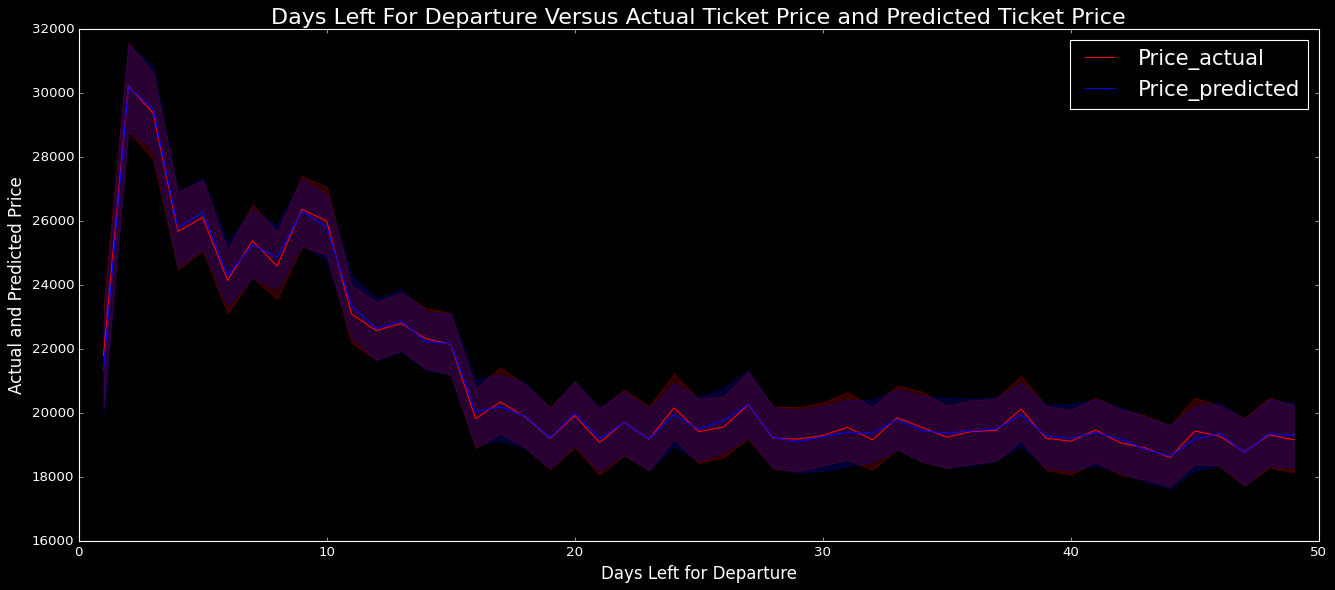

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=result,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=result,x='days_left',y='Price_pred',color='blue')
plt.title('Days Left For Departure Versus Actual Ticket Price and Predicted Ticket Price',fontsize=20)
plt.legend(labels=['Price_actual','Price_predicted'],fontsize=19)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Actual and Predicted Price',fontsize=15)
plt.show()

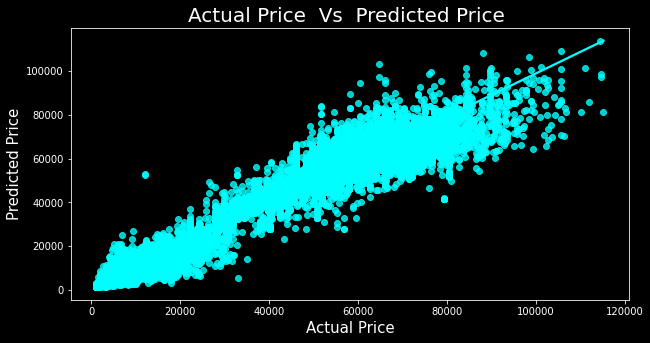

In [ ]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=result,color='cyan')
plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

Training the Data with LinearRegressor

In [ ]:
#Trainig the model with
modelmlg.fit(x_train, y_train)
    
# Predict the model with test data

y_pred = modelmlg.predict(x_test)


In [ ]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df_bk.merge(out,left_index=True,right_index=True)

In [ ]:
#result.sample(10)


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
102069,AirAsia,I5-334,Bangalore,Night,0,Late Night,Mumbai,economy,120,46,2201,2201,-3919.424051
195615,GO FIRST,G8-305,Chennai,Morning,1,Evening,Bangalore,economy,490,23,9999,9999,5520.161947
118084,Vistara,UK-864,Bangalore,Evening,1,Morning,Chennai,economy,1010,31,4792,4792,8340.066359
189785,Indigo,6E-5331,Chennai,Early Morning,0,Early Morning,Mumbai,economy,110,19,3000,3000,1251.390031
26052,GO FIRST,G8-101,Delhi,Early Morning,0,Morning,Kolkata,economy,130,35,3999,3999,-1684.302565
183862,Vistara,UK-834,Chennai,Evening,0,Evening,Delhi,economy,165,26,2366,2366,1665.296411
251079,Vistara,UK-820,Bangalore,Evening,1,Night,Mumbai,business,360,28,67004,67004,53820.234412
26488,Air India,AI-665,Delhi,Morning,1,Morning,Kolkata,economy,1490,37,5276,5276,5167.721847
160260,Air India,AI-9893,Hyderabad,Early Morning,1,Evening,Mumbai,economy,690,14,13276,13276,6500.893642
192632,Air India,AI-430,Chennai,Morning,1,Night,Mumbai,economy,605,39,4357,4357,3927.265203


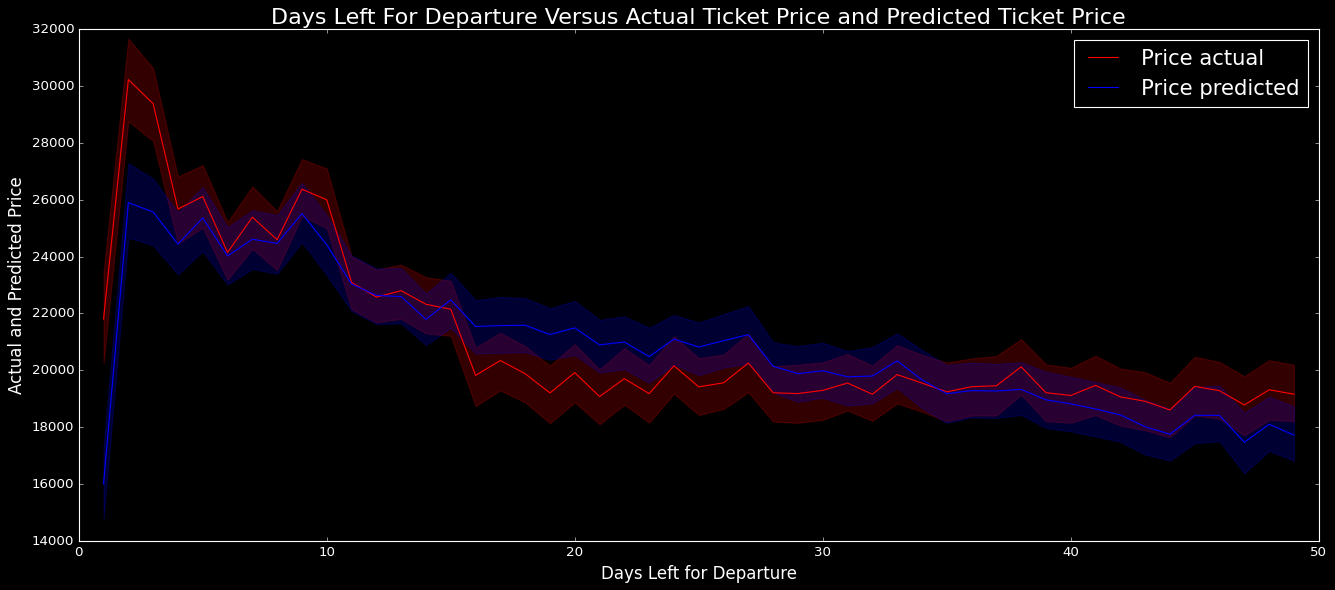

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=result,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=result,x='days_left',y='Price_pred',color='blue')
plt.title('Days Left For Departure Versus Actual Ticket Price and Predicted Ticket Price',fontsize=20)
plt.legend(labels=['Price actual','Price predicted'],fontsize=19)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Actual and Predicted Price',fontsize=15)
plt.show()

In the below graph, we can observe a clear difference in cluster of points, 

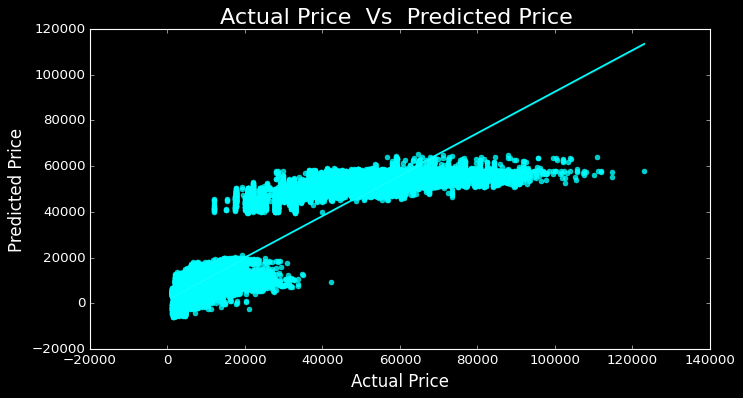

In [ ]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=result,color='cyan')
plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

Training the Data with LassoRegressor

In [ ]:
#Trainig the model with
modelLO.fit(x_train, y_train)
    
# Predict the model with test data

y_pred = modelLO.predict(x_test)


In [ ]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df_bk.merge(out,left_index=True,right_index=True)

In [ ]:
result.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
17490,SpiceJet,SG-8645,Delhi,Evening,1,Morning,Bangalore,economy,1000,37,6427,6427,5661.088094
13372,AirAsia,I5-744,Delhi,Morning,1,Evening,Bangalore,economy,595,19,3090,3090,5397.032696
79739,Vistara,UK-910,Mumbai,Evening,1,Morning,Chennai,economy,980,19,4998,4998,10470.079982
43279,AirAsia,I5-942,Mumbai,Afternoon,1,Late Night,Delhi,economy,735,3,7251,7251,8134.369375
263577,Vistara,UK-774,Kolkata,Night,1,Evening,Delhi,business,1290,40,66063,66063,53438.241803
66869,SpiceJet,SG-8702,Mumbai,Morning,1,Morning,Kolkata,economy,1370,31,5818,5818,8276.233780
188712,Air India,AI-440,Chennai,Early Morning,1,Night,Mumbai,economy,960,11,9141,9141,7762.125384
243339,Air India,AI-888,Mumbai,Evening,1,Evening,Chennai,business,1440,26,49613,49613,50887.241646
68989,Vistara,UK-950,Mumbai,Night,1,Evening,Kolkata,economy,1300,42,5949,5949,8435.871892
19048,Vistara,UK-829,Delhi,Early Morning,1,Morning,Bangalore,economy,1545,45,3357,3357,7317.515874


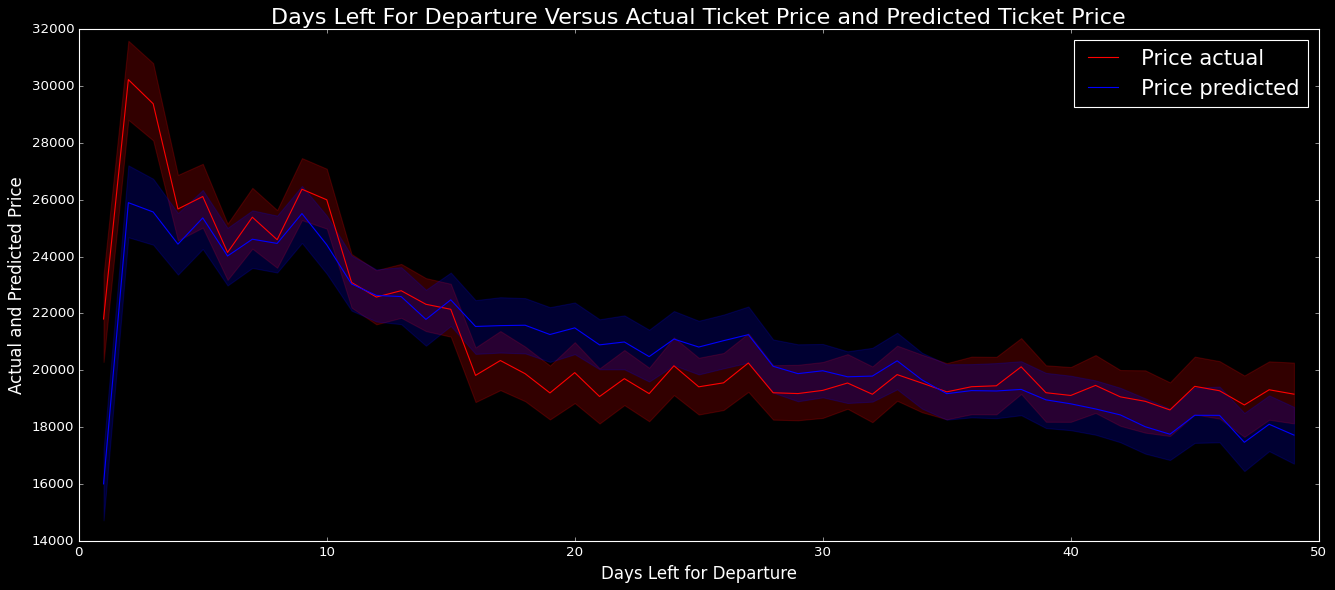

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=result,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=result,x='days_left',y='Price_pred',color='blue')
plt.title('Days Left For Departure Versus Actual Ticket Price and Predicted Ticket Price',fontsize=20)
plt.legend(labels=['Price actual','Price predicted'],fontsize=19)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Actual and Predicted Price',fontsize=15)
plt.show()

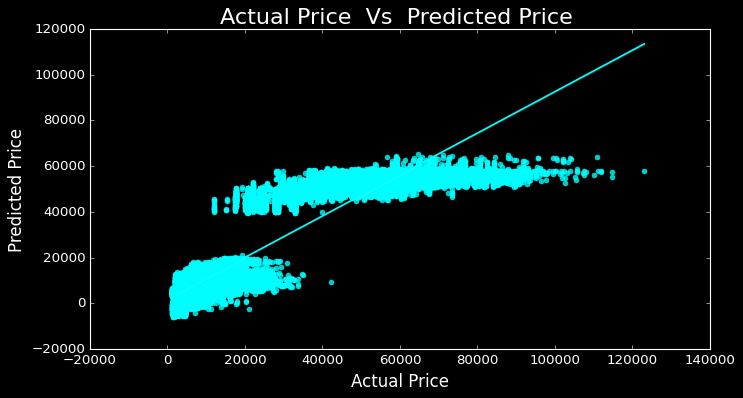

In [ ]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=result,color='cyan')
plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()

Training the Data with KNN Regressor

In [ ]:
#Trainig the model with
modelKNN.fit(x_train, y_train)
    
# Predict the model with test data

y_pred = modelKNN.predict(x_test)


In [ ]:
out=pd.DataFrame({'Price_actual':y_test,'Price_pred':y_pred})
result=df_bk.merge(out,left_index=True,right_index=True)

In [ ]:
result.sample(10)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Price_actual,Price_pred
204031,Indigo,6E-6113,Chennai,Afternoon,1,Night,Hyderabad,economy,355,17,2862,2862,3286.4
253934,Air India,AI-808,Bangalore,Night,1,Morning,Kolkata,business,720,17,60508,60508,60508.0
72787,Air India,AI-867,Mumbai,Night,1,Night,Hyderabad,economy,1385,19,4593,4593,5937.4
21088,Vistara,UK-943,Delhi,Early Morning,1,Evening,Kolkata,economy,745,7,14355,14355,14250.0
71169,Vistara,UK-960,Mumbai,Morning,1,Evening,Hyderabad,economy,480,8,9879,9879,10236.2
32677,AirAsia,I5-747,Delhi,Evening,1,Morning,Hyderabad,economy,825,31,5149,5149,3273.0
76665,Vistara,UK-873,Mumbai,Early Morning,0,Early Morning,Hyderabad,economy,90,45,3450,3450,3450.0
219349,Vistara,UK-829,Delhi,Early Morning,0,Morning,Hyderabad,business,130,4,38470,38470,24504.0
187777,Vistara,UK-838,Chennai,Night,1,Night,Mumbai,economy,1545,3,11783,11783,15720.4
163177,GO FIRST,G8-426,Hyderabad,Night,1,Afternoon,Mumbai,economy,870,33,4165,4165,4165.0


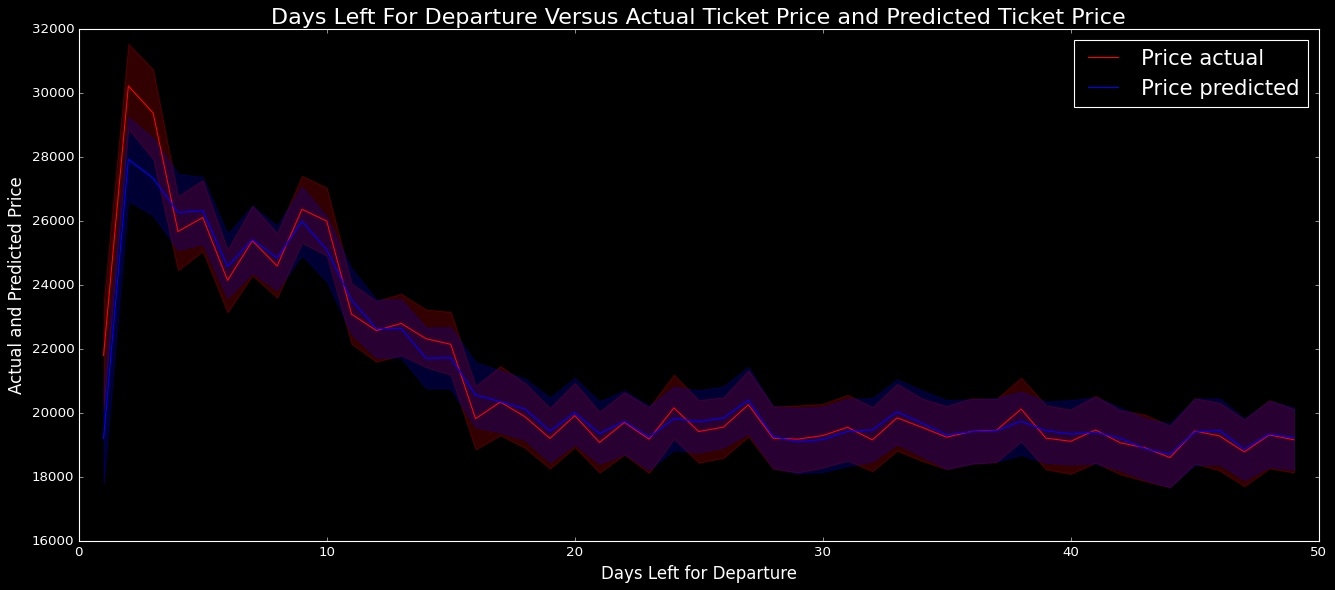

In [ ]:
plt.figure(figsize=(20,8))
sns.lineplot(data=result,x='days_left',y='Price_actual',color='red')
sns.lineplot(data=result,x='days_left',y='Price_pred',color='blue')
plt.title('Days Left For Departure Versus Actual Ticket Price and Predicted Ticket Price',fontsize=20)
plt.legend(labels=['Price actual','Price predicted'],fontsize=19)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Actual and Predicted Price',fontsize=15)
plt.show()

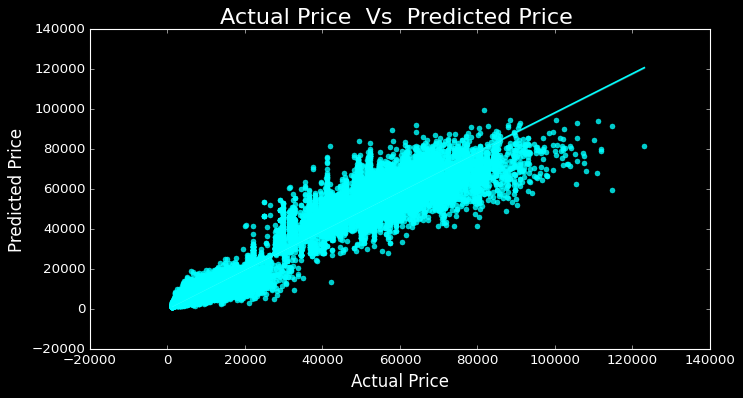

In [ ]:
plt.figure(figsize=(10,5))
sns.regplot(x='Price_actual',y='Price_pred',data=result,color='cyan')
plt.title('Actual Price  Vs  Predicted Price ',fontsize=20)
plt.xlabel('Actual Price',fontsize=15)
plt.ylabel('Predicted Price',fontsize=15)
plt.show()